In [1]:
NAME1 = "Caroline Andersson" 
NAME2 = "Adam Burman"
GROUP = "84"

In [2]:
### Check Python version
from platform import python_version_tuple
assert python_version_tuple()[:2] == ('3','9'), "You are not running Python 3.9. Make sure to run Python through the course Conda environment."

### 1.1 Imports

In [3]:


path = r"C:\Users\carol\Deep Machine Learning\project\Dataset"

import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.transforms import Resize
from torchvision.transforms import CenterCrop
from pathlib import Path
import torchvision.transforms
import torch.nn.functional as F
from torch.utils.data import random_split

from torch import nn
from torch import optim

import matplotlib.pyplot as plt
import numpy as np

import torchvision.transforms as transforms
#import colorspacious as cs


import kornia # https://kornia.readthedocs.io/en/latest/color.html
#Lab color is computed using the D65 illuminant and Observer 2. (deafult in kornia)


from torchvision.transforms import Compose

In [4]:
# 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|---------------------------------------------------------------------------|\n| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |

### 1.2 Load Data

Make a dataloader class

### 1.2.1 Load GTA Data and Return L, ab // or [1, s, s], [2, s, s]

In [5]:
from torch.utils.data import Dataset
from itertools import chain
from PIL import Image
import glob
import os

class GTALabData(Dataset):
    

    def __init__(self, root, transform = None):
            """Constructor
        
        Args:
            root (Path/str): Filepath to the data root
            transform (Compose): A composition of image transforms.
        """
            root = Path(root)
            if not (root.exists() and root.is_dir()):
                raise ValueError(f"Data root '{root}' is invalid")
            
            self.root = root
            self.transform = transform
            self.img_paths, self.label_paths = self._collect_samples()
            
       
    def __getitem__(self, index):
        """Get sample by index
        
        Args:
            index (int)
        
        Returns:
             The index'th sample Tensor
        """
        
        img_path = self.img_paths[index]
        label_path = self.label_paths[index]

        # Load the image and label into memory
        img = Image.open(img_path)
        #label = Image.open(label_path)
        img1 = torchvision.transforms.functional.pil_to_tensor(img) # PIL --> Tensor
        img = kornia.color.rgb_to_lab(img1/255) # RGB --> Lab
        
        L = img[0]#kornia.color.rgb_to_grayscale(img1/255)#img[0]
        a = img[1]
        b = img[2]

        # Perform transforms, if any.
        if self.transform is not None:
            L = self.transform(L.numpy()) # transform L
            a = self.transform(a.numpy()) # transform
            b = self.transform(b.numpy()) # transform
            
            
        
        
        ab = torch.cat((a.unsqueeze(0), b.unsqueeze(0)), dim=0).squeeze()
        #L = torch.cat((L.unsqueeze(0), L.unsqueeze(0), L.unsqueeze(0)), dim=0).squeeze()

        return (L-50)/50, ab/128
    
    def __len__(self):
        """Get the number of samples in the dataset"""
        return len(self.img_paths)
    
    def _collect_samples(self):
        """Collect all paths and labels
        
        Helper method for the constructor
        """
        """Collect all paths and labels

        Helper method for the constructor
        """
        
        
        # Get image and label paths
        img_dir = self.root / "01_images" / "images"
        label_dir = self.root / "01_labels" / "labels"
        
        # check if there are images in the directory
        #self._check_images_in_directory(img_dir)
        #self._check_images_in_directory(label_dir)

        img_paths = list(img_dir.glob("*.png"))
        label_paths = list(label_dir.glob("*.png"))

        if len(img_paths) != len(label_paths):
            raise ValueError("Number of images and labels must be the same")
            
        return img_paths, label_paths

In [6]:

transform = Compose([ToTensor()])

example_dataset = GTALabData(path, transform)
print(len(example_dataset)) #1
L, ab = example_dataset[2]


2500
torch.float32
torch.Size([1052, 1914])
torch.Size([2, 1052, 1914])
1.0


### 1.2.1 Load GTA Data and Return L, (L, segmented image) // or [1, s, s], [2, s, s]

In [7]:

# GTASemanticData
# Note: there are 19 semantic classes
from torch.utils.data import Dataset
from itertools import chain
from PIL import Image
import glob
import os

class GTASegData(Dataset):
    

    def __init__(self, root, transform = None):
            """Constructor
        
        Args:
            root (Path/str): Filepath to the data root
            transform (Compose): A composition of image transforms.
        """
            root = Path(root)
            if not (root.exists() and root.is_dir()):
                raise ValueError(f"Data root '{root}' is invalid")
            
            self.root = root
            self.transform = transform
            self.img_paths, self.label_paths = self._collect_samples()
            
       
    def __getitem__(self, index):
        """Get sample by index
        
        Args:
            index (int)
        
        Returns:
             The index'th sample Tensor
        """
        
        img_path = self.img_paths[index]
        label_path = self.label_paths[index]

        # Load the image and label into memory
        img = Image.open(img_path)
        label = Image.open(label_path)
        
        img1 = torchvision.transforms.functional.pil_to_tensor(img) # PIL --> Tensor
        img = kornia.color.rgb_to_lab(img1/255) # RGB --> Lab



       
        L = img[0]
        a = img[1]
        b = img[2]

        

        # Perform transforms, if any.
        if self.transform is not None:
            L = self.transform(L.numpy()) # transform L
            label = self.transform(label) # transform
            a = self.transform(a.numpy()) # transform
            b = self.transform(b.numpy()) # transform

        label1 =np.moveaxis(label.numpy()*255, 0, -1)
        label1 = torch.from_numpy(label1).float().permute(2,0,1).int() # turn label into integers after resize transform
        
        # Generate 35 tensors with zeros
        
        zeros = torch.zeros((35,L.shape[1], L.shape[2]))
       
        for value in range(35):
            find_class = (label1 == value).float()
            zeros[value] = label1*find_class
        
            

        #n_digits = 2
        #label = torch.round(label * 10**n_digits) / (10**n_digits) #round to 3 decimals
        
        
        
        
        
        
        ab = torch.cat((a.unsqueeze(0), b.unsqueeze(0)), dim=0).squeeze()
        out = torch.cat((L.unsqueeze(0)/100, label.unsqueeze(0)), dim=0).squeeze()

        return L/100, label1 # normalize L between [0, 1] to fit in cross entropy loss
    
    def __len__(self):
        """Get the number of samples in the dataset"""
        return len(self.img_paths)
    
    def _collect_samples(self):
        """Collect all paths and labels
        
        Helper method for the constructor
        """
        """Collect all paths and labels

        Helper method for the constructor
        """
        
        
        # Get image and label paths
        img_dir = self.root / "01_images" / "images"
        label_dir = self.root / "01_labels" / "labels"
        
        # check if there are images in the directory
        #self._check_images_in_directory(img_dir)
        #self._check_images_in_directory(label_dir)

        img_paths = list(img_dir.glob("*.png"))
        label_paths = list(label_dir.glob("*.png"))

        if len(img_paths) != len(label_paths):
            raise ValueError("Number of images and labels must be the same")
            
        return img_paths, label_paths


torch.Size([1, 512, 512])


(-0.5, 511.5, 511.5, -0.5)

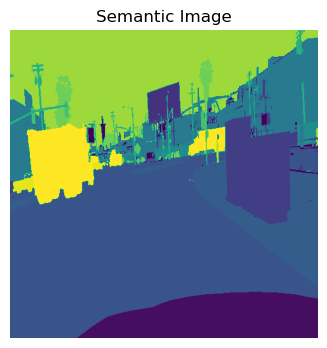

In [8]:
crop_size = (512, 512)
transform =  Compose([ToTensor(), Resize(crop_size, interpolation=Image.NEAREST)])
example_dataset1 = GTASegData(path, transform)
L1, s = example_dataset1[5]

plt.figure(figsize=(8, 4))
plt.imshow(torch.sum(s, dim= 0).numpy().squeeze())
plt.title('Semantic Image')
plt.axis('off')

### 1.3 Augument

In [9]:
# Dataset 
mean = 52.37087932
std = 24.64118381
img_size = 128#224
#gta_transform = Compose([ToTensor(), Resize((img_size, img_size), antialias=True), Normalize(mean, std, inplace=False)]) 
gta_transform = Compose([ToTensor(), Resize((img_size, img_size), antialias=True)])
gta_dataset = GTALabData(path, gta_transform)

### 1.4 Chop up into train, val and test

In [10]:

val_ratio = 0.15
test_ratio = 0.15

n_samples = len(gta_dataset)
n_val_samples = int(n_samples * val_ratio)
n_test_samples = int(n_samples * test_ratio)
n_train_samples = n_samples - n_val_samples - n_test_samples

train_dataset, val_dataset, test_dataset = random_split(
    gta_dataset, [n_train_samples, n_val_samples, n_test_samples]
)

0.9710671
-0.9831371


##  2. Create an Autoenconder for the Raw images


### 2.1 Create the Class

In [11]:


class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Endocer
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        
        #Decoder
        
        self.dconv1 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.dbn1 = nn.BatchNorm2d(128)
        self.dconv2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.dbn2 = nn.BatchNorm2d(64)
        self.dconv3 = nn.Conv2d(64, 2, kernel_size=3, padding=1)  # Output has 2 channels (ab color channels)
        self.relu = nn.LeakyReLU(inplace=True)
        self.tanh = nn.Tanh()

        self.dropout1 = nn.Dropout(0.5)  # Adjust the dropout probability as needed
        self.dropout2 = nn.Dropout(0.1)
        
    def forward(self, x):
        # Encoder
        
        x = self.conv1(x)

        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        
        x = self.dropout1(x)
        # Decoder
        
        x = self.dconv1(x)
        x = self.tanh(x)
        x = self.dbn1(x)
        x = self.dconv2(x)
        x = self.dbn2(x)
        x = self.tanh(x)
        x = self.dconv3(x)
        x = self.dropout2(x)
        
        
        x = self.tanh(x)
        
        # Perform upsampling to the desired size [1052, 1914]
        #x = F.interpolate(x, size=(1052, 1914), mode='bilinear', align_corners=False)
       
        
        return x




### 2.2 Train 

In [12]:
def training_loop(model, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every):
    print("Starting training")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    train_losses, val_losses = [], []

    for epoch in range(1, num_epochs + 1):
        model, train_loss = train_epoch(model, optimizer, loss_fn, train_loader, device, print_every)
        val_loss = validate(model, loss_fn, val_loader, device)
        print(f"Epoch {epoch}/{num_epochs}: "
              f"Train loss: {train_loss:.3f}, "
              f"Val. loss: {val_loss:.3f}")
        train_losses.append(train_loss)
        val_losses.append(val_loss)
    
    return model, train_losses, val_losses

def train_epoch(model, optimizer, loss_fn, train_loader, device, print_every):
    model.train()
    train_loss_batches = []
    num_batches = len(train_loader)
    
    for batch_index, (x, y) in enumerate(train_loader, 1):
        inputs, labels = x.to(device), y.to(device)
        optimizer.zero_grad()
        z = model(inputs)
        loss = loss_fn(z, labels)
        loss.backward()
        optimizer.step()
        train_loss_batches.append(loss.item())

        if print_every is not None and batch_index % print_every == 0:
            model.train()
            print(f"Batch {batch_index}/{num_batches}: Train loss: {sum(train_loss_batches[-print_every:])/print_every:.3f}")

    return model, sum(train_loss_batches) / len(train_loss_batches)

def validate(model, loss_fn, val_loader, device):
    val_loss_cum = 0
    model.eval()
    with torch.no_grad():
        for batch_index, (x, y) in enumerate(val_loader, 1):
            inputs, labels = x.to(device), y.to(device)
            z = model(inputs)
            batch_loss = loss_fn(z, labels)
            val_loss_cum += batch_loss.item()
    return val_loss_cum / len(val_loader)


In [55]:
# YOUR CODE HERE
batch_size = 32
base_model = AutoEncoder()

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)



optimizer = optim.Adam(base_model.parameters(), lr =0.001)
loss_fn = nn.MSELoss()
num_epochs = 10
print_every = 2


    
trained_single_model, train_losses, val_losses = training_loop(base_model, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every)

Starting training
Batch 2/55: Train loss: 0.294
Batch 4/55: Train loss: 0.271
Batch 6/55: Train loss: 0.076
Batch 8/55: Train loss: 0.017
Batch 10/55: Train loss: 0.035
Batch 12/55: Train loss: 0.009
Batch 14/55: Train loss: 0.016
Batch 16/55: Train loss: 0.015
Batch 18/55: Train loss: 0.006
Batch 20/55: Train loss: 0.011
Batch 22/55: Train loss: 0.008
Batch 24/55: Train loss: 0.005
Batch 26/55: Train loss: 0.008
Batch 28/55: Train loss: 0.005
Batch 30/55: Train loss: 0.005
Batch 32/55: Train loss: 0.005
Batch 34/55: Train loss: 0.004
Batch 36/55: Train loss: 0.004
Batch 38/55: Train loss: 0.004
Batch 40/55: Train loss: 0.003
Batch 42/55: Train loss: 0.004
Batch 44/55: Train loss: 0.003
Batch 46/55: Train loss: 0.003
Batch 48/55: Train loss: 0.003
Batch 50/55: Train loss: 0.003
Batch 52/55: Train loss: 0.003
Batch 54/55: Train loss: 0.003
Epoch 1/10: Train loss: 0.030, Val. loss: 0.003
Batch 2/55: Train loss: 0.003
Batch 4/55: Train loss: 0.003
Batch 6/55: Train loss: 0.003
Batch 8/55:

### 2.3 Evaluate Performance

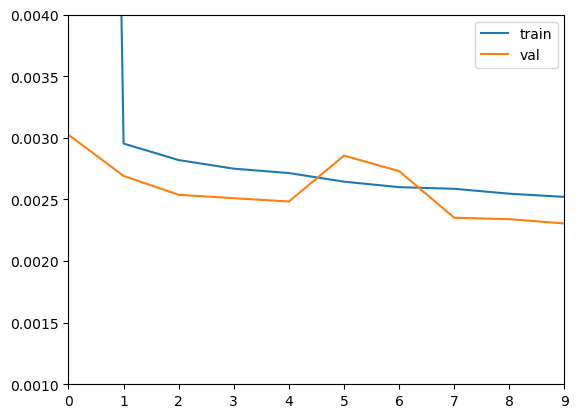

In [62]:
plt.figure()
plt.plot(range(0,len(train_losses)), train_losses)
plt.plot(range(0,len(val_losses)), val_losses)
plt.legend(['train', 'val'])
plt.ylim([0.001, 0.004])
plt.xlim([0, 9])
plt.show()
# Train loss: 0.013, Val. loss: 0.003

18.0219


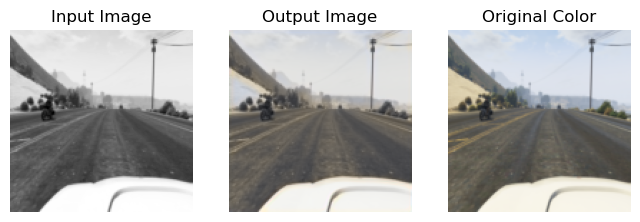

27.38561


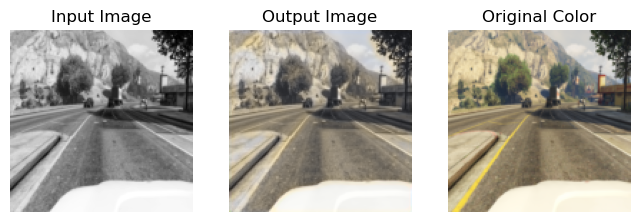

18.144978


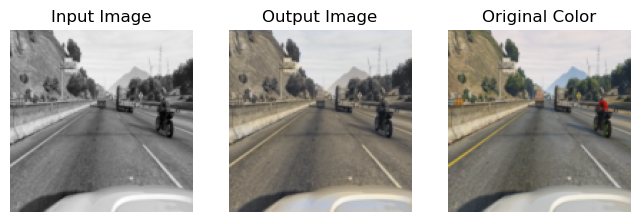

23.344688


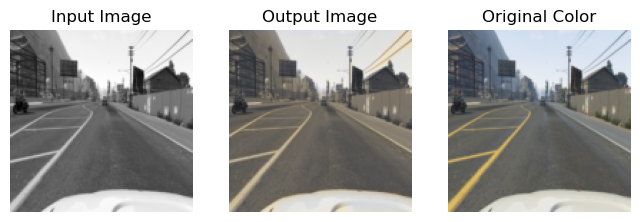

16.883806


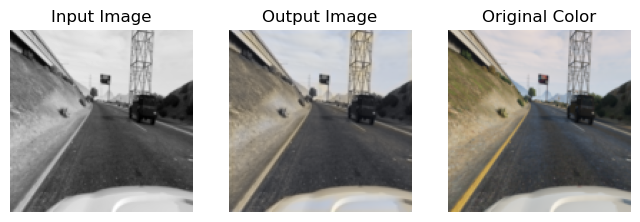

15.444447


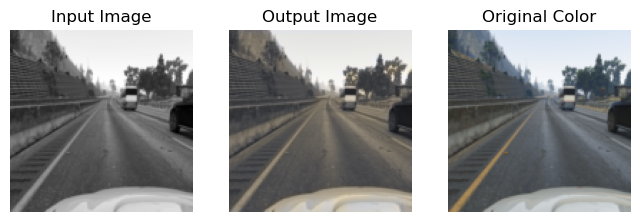

19.037624


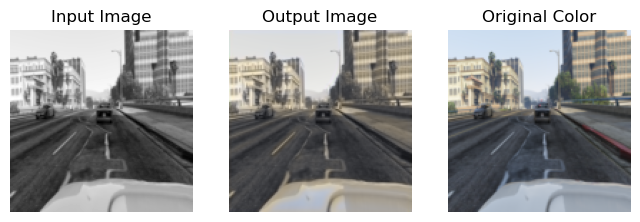

19.999249


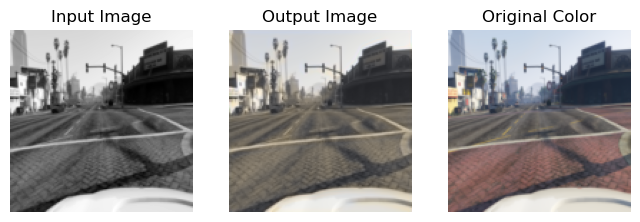

26.028042


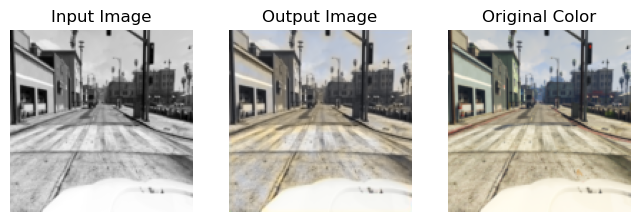

In [58]:

trained_single_model.eval()
batch_size = 10
# Iterate through the test data
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

counter = 0
for batch in test_loader:
    inputs, labels = batch  # You can ignore the labels
    if counter == 3:
        break
    else:
        counter += 1

    # Perform inference
    with torch.no_grad():
        outputs = trained_single_model(inputs.to(device))

    # View the input and output images
    for i in range(3):
        input_img = inputs[i].squeeze().cpu()*50 + 50 # rescale [-1,1] --> [0, 100]
        input_labels = labels[i].squeeze().cpu()*128 # rescale [-1,1] --> [-128, 128]
        output_img = outputs[i].cpu()*128 # rescale [-1,1] --> [-128, 128]
        print(np.max(output_img.numpy()))
        

        # Network computed image
        color_img = torch.cat((input_img.unsqueeze(0) ,output_img[0].unsqueeze(0), output_img[1].unsqueeze(0)), dim=0).cpu() # restore Lab image
        color_img = kornia.color.lab_to_rgb(color_img) #Lab --> RGB
        color_img = color_img.permute(1, 2, 0).cpu().numpy()
        

        # Original Image
        input_labels = F.interpolate(input_labels.unsqueeze(1), size=(img_size, img_size), mode='bilinear', align_corners=False).squeeze(1).cpu()
        original_color_image = torch.cat((input_img.unsqueeze(0) ,input_labels[0].unsqueeze(0), input_labels[1].unsqueeze(0)), dim=0)
        original_color_image = kornia.color.lab_to_rgb(original_color_image)


        # Display the input and output images side by side
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(input_img, cmap='gray')
        plt.title('Input Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(color_img)
        plt.title('Output Image')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(original_color_image.permute(1, 2, 0).numpy())
        plt.title('Original Color')
        plt.axis('off')

        plt.show()

#output = trained_gta_model(test_image)
#test_dataloader = DataLoader()

### 2.4 Save Model

In [59]:
torch.save({'model_state_dict': trained_single_model.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            }, "./trained_single_model.ckpt")

# Example of creating and initialising model with a previously saved state dict:
saved_seg_model = AutoEncoder() # fill-in the arguments if needed
checkpoint = torch.load("trained_single_model.ckpt")
saved_seg_model.load_state_dict(checkpoint['model_state_dict'])

# Example of re-using saved statistics:
print("Validation accuracies:", checkpoint['val_losses'])

Validation accuracies: [0.00302524664827312, 0.0026912673104864857, 0.00253819222173964, 0.0025101784073437252, 0.00248371382864813, 0.0028562013370295367, 0.002730250300373882, 0.0023515253754643104, 0.002340329713964214, 0.002305300246613721]


## 3. Create a Network for Semantic Segmentation

In [19]:
def training_loop_seg(model, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every):
    print("Starting training")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    train_losses, val_losses = [], []

    for epoch in range(1, num_epochs + 1):
        model, train_loss = train_epoch(model, optimizer, loss_fn, train_loader, device, print_every)
        val_loss = validate(model, loss_fn, val_loader, device)
        print(f"Epoch {epoch}/{num_epochs}: "
              f"Train loss: {train_loss:.3f}, "
              f"Val. loss: {val_loss:.3f}")
        train_losses.append(train_loss)
        val_losses.append(val_loss)
    
    return model, train_losses, val_losses

def train_epoch(model, optimizer, loss_fn, train_loader, device, print_every):
    model.train()
    train_loss_batches = []
    num_batches = len(train_loader)
    
    for batch_index, (x, y) in enumerate(train_loader, 1):
        inputs, labels = x.to(device), y.to(device)
        optimizer.zero_grad()
        z = model(inputs)
        
        loss = loss_fn(z, labels.squeeze(1))
        loss.backward()
        optimizer.step()
        train_loss_batches.append(loss.item())

        if print_every is not None and batch_index % print_every == 0:
            model.train()
            print(f"Batch {batch_index}/{num_batches}: Train loss: {sum(train_loss_batches[-print_every:])/print_every:.3f}")

    return model, sum(train_loss_batches) / len(train_loss_batches)

def validate(model, loss_fn, val_loader, device):
    val_loss_cum = 0
    model.eval()
    with torch.no_grad():
        for batch_index, (x, y) in enumerate(val_loader, 1):
            inputs, labels = x.to(device), y.to(device)
            z = model(inputs)
            batch_loss = loss_fn(z, labels.squeeze(1).long())
            val_loss_cum += batch_loss.item()
    return val_loss_cum / len(val_loader)


In [14]:
import torch.nn as nn

class SegModel(nn.Module):
    def __init__(self):
        super().__init__()

        # Define the layers for the encoder (downsampling)
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout(0.3)
        

        # Define the layers for the decoder (upsampling)
        self.conv4 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU(inplace=True)
        self.upsample = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=False)
        self.conv5 = nn.Conv2d(128, 35, kernel_size=1)  # Output layer with 1 channel
        self.dropout2 = nn.Dropout(0.2)

    def forward(self, x):
        # Encoder
        #x = x.squeeze(1)
        #x = x.permute(0, 2, 3, 1)  # Change shape from [3, 1, 128, 128] to [3, 128, 128, 1]
        #print(x.shape)
        input_img = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        #x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        #x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.relu3(x)

        # Decoder
        x = self.conv4(x)
        x = self.relu4(x)
        #x = self.upsample(x)
        x = self.dropout2(x)
        x = self.conv5(x)
        x = self.relu4(x)
        #x = torch.round(x)
        #print(x.shape)
        #out = torch.cat((input_img, x), dim=1)
        
        return x


In [53]:
crop_size= (128,128)
gta_seg_transform = Compose([ToTensor(), Resize(crop_size, interpolation=Image.NEAREST)])
gta_seg_dataset = GTASegData(path, gta_seg_transform)
img, label = gta_seg_dataset[0]

val_ratio = 0.15
test_ratio = 0.15

n_samples = len(gta_seg_dataset)
n_val_samples = int(n_samples * val_ratio)
n_test_samples = int(n_samples * test_ratio)
n_train_samples = n_samples - n_val_samples - n_test_samples

s_train_dataset, s_val_dataset, s_test_dataset = random_split(
    gta_seg_dataset, [n_train_samples, n_val_samples, n_test_samples]
)

In [370]:
# YOUR CODE HERE
batch_size = 32


seg_color_model = SegModel()

train_loader = DataLoader(s_train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(s_val_dataset, batch_size=batch_size, shuffle=True)



optimizer = optim.Adam(seg_color_model.parameters(), lr =0.001)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 10
print_every = 1


# 2.284, 1.955 4 layers
# 2.746, 2.821 3 layers
#  2.245, 2.069  6 layers
# 2.821, 2.741 6 layers and dropout, slower but steadier. If trained for 1 epoch 28 batches --> 1.941, 1.958 pretty good
# 2.352, 3.216 one extra bn in decoder, extremely bad
# up and down sampling
trained_seg_model, train_seg_losses, val_seg_losses = training_loop_seg(seg_color_model, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every)

Starting training
Batch 1/55: Train loss: 3.577
Batch 2/55: Train loss: 3.200
Batch 3/55: Train loss: 2.687
Batch 4/55: Train loss: 2.274
Batch 5/55: Train loss: 2.144
Batch 6/55: Train loss: 2.323
Batch 7/55: Train loss: 2.172
Batch 8/55: Train loss: 1.951
Batch 9/55: Train loss: 2.086
Batch 10/55: Train loss: 1.985
Batch 11/55: Train loss: 1.913
Batch 12/55: Train loss: 1.880
Batch 13/55: Train loss: 1.993
Batch 14/55: Train loss: 1.795
Batch 15/55: Train loss: 1.944
Batch 16/55: Train loss: 1.898
Batch 17/55: Train loss: 2.145
Batch 18/55: Train loss: 1.838
Batch 19/55: Train loss: 2.010
Batch 20/55: Train loss: 1.674
Batch 21/55: Train loss: 1.793
Batch 22/55: Train loss: 1.673
Batch 23/55: Train loss: 1.759
Batch 24/55: Train loss: 1.754
Batch 25/55: Train loss: 1.668
Batch 26/55: Train loss: 1.738
Batch 27/55: Train loss: 1.759
Batch 28/55: Train loss: 1.741
Batch 29/55: Train loss: 1.723
Batch 30/55: Train loss: 1.892
Batch 31/55: Train loss: 1.731
Batch 32/55: Train loss: 1.684

## 3.2 Evaluate results

torch.Size([35, 128, 128])
torch.Size([128, 128])
tensor([[23, 23, 23,  ..., 23, 23, 23],
        [23, 23, 23,  ..., 23, 23, 23],
        [23, 23, 23,  ..., 23, 23, 23],
        ...,
        [ 7,  7,  7,  ...,  1,  1,  1],
        [ 7,  7,  7,  ...,  1,  1,  1],
        [ 7,  7,  7,  ...,  1,  1,  1]])


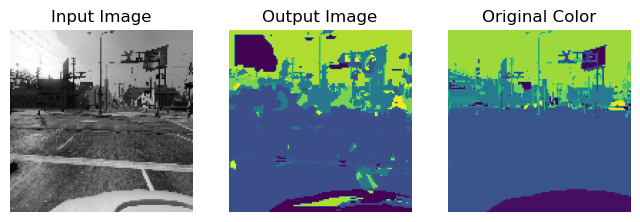

torch.Size([35, 128, 128])
torch.Size([128, 128])
tensor([[23, 23, 23,  ..., 11, 11, 11],
        [23, 23, 23,  ..., 11, 11, 11],
        [23, 23, 23,  ..., 11, 11, 11],
        ...,
        [ 7,  7,  7,  ...,  1,  1,  1],
        [ 7,  7,  7,  ...,  1,  1,  1],
        [ 7,  7,  7,  ...,  1,  1,  1]])


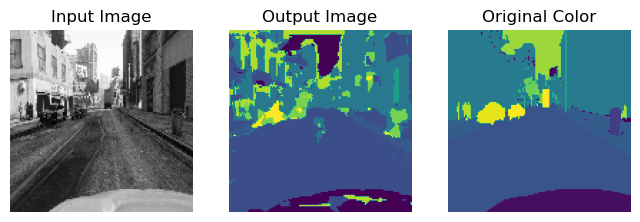

torch.Size([35, 128, 128])
torch.Size([128, 128])
tensor([[23, 23, 23,  ..., 23, 23, 23],
        [23, 23, 23,  ..., 23, 23, 23],
        [23, 23, 23,  ..., 23, 23, 23],
        ...,
        [ 7,  7,  7,  ...,  1,  1,  1],
        [ 7,  7,  7,  ...,  1,  1,  1],
        [ 7,  7,  7,  ...,  1,  1,  1]])


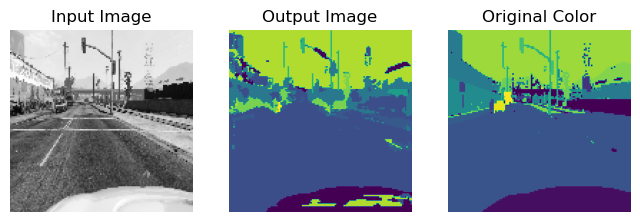

torch.Size([35, 128, 128])
torch.Size([128, 128])
tensor([[11, 11, 11,  ..., 23, 23, 23],
        [11, 11, 11,  ..., 23, 23, 23],
        [11, 11, 11,  ..., 23, 23, 23],
        ...,
        [ 7,  7,  7,  ...,  1,  1,  1],
        [ 7,  7,  7,  ...,  1,  1,  1],
        [ 7,  7,  7,  ...,  1,  1,  1]])


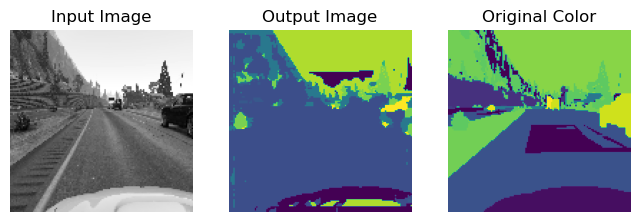

torch.Size([35, 128, 128])
torch.Size([128, 128])
tensor([[23, 23, 23,  ..., 11, 11, 11],
        [23, 23, 23,  ..., 11, 11, 11],
        [23, 23, 23,  ..., 11, 11, 11],
        ...,
        [ 7,  7,  7,  ...,  1,  1,  1],
        [ 7,  7,  7,  ...,  1,  1,  1],
        [ 7,  7,  7,  ...,  1,  1,  1]])


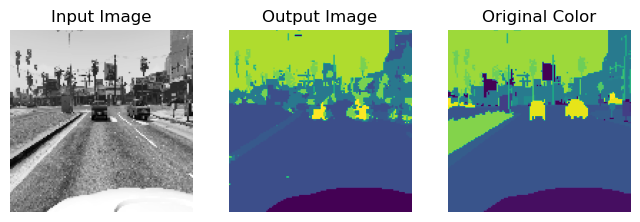

torch.Size([35, 128, 128])
torch.Size([128, 128])
tensor([[11, 11, 11,  ..., 23, 11, 11],
        [11, 11, 11,  ..., 23, 11, 11],
        [11, 11, 11,  ..., 23, 11, 11],
        ...,
        [ 7,  7,  7,  ...,  1,  1,  1],
        [ 7,  7,  7,  ...,  1,  1,  1],
        [ 7,  7,  7,  ...,  1,  1,  1]])


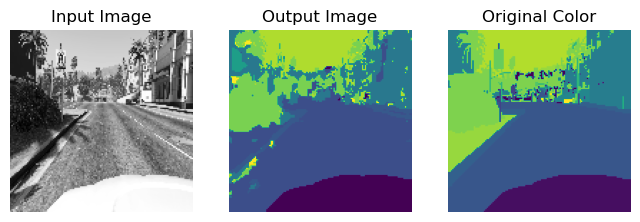

torch.Size([35, 128, 128])
torch.Size([128, 128])
tensor([[11, 11, 21,  ..., 21, 21, 21],
        [21, 21, 21,  ..., 21, 21, 21],
        [21, 23, 21,  ..., 21, 23, 21],
        ...,
        [ 7,  7,  7,  ...,  1,  1,  1],
        [ 7,  7,  7,  ...,  1,  1,  1],
        [ 7,  7,  7,  ...,  1,  1,  1]])


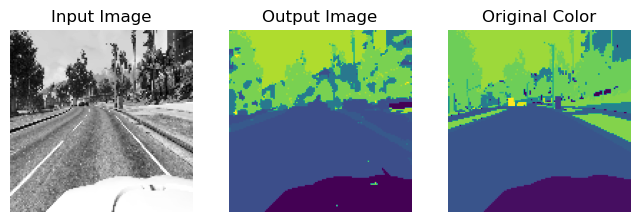

torch.Size([35, 128, 128])
torch.Size([128, 128])
tensor([[23, 11, 23,  ..., 11, 11, 11],
        [11, 23, 23,  ..., 23, 23, 23],
        [23, 23, 23,  ..., 23, 23, 23],
        ...,
        [ 7,  7,  7,  ...,  1,  1, 11],
        [ 7,  7,  7,  ...,  1,  7,  7],
        [ 7,  7,  7,  ...,  1,  1,  1]])


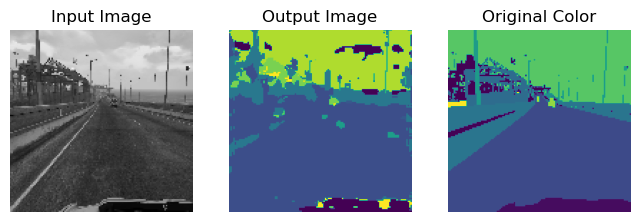

torch.Size([35, 128, 128])
torch.Size([128, 128])
tensor([[23, 23, 23,  ..., 11, 11, 11],
        [23, 23, 23,  ..., 11, 11, 11],
        [23, 23, 23,  ..., 11, 11, 11],
        ...,
        [ 7,  7,  7,  ...,  1,  1,  1],
        [ 7,  7,  7,  ...,  1,  1,  1],
        [ 7,  7,  7,  ...,  1,  1,  1]])


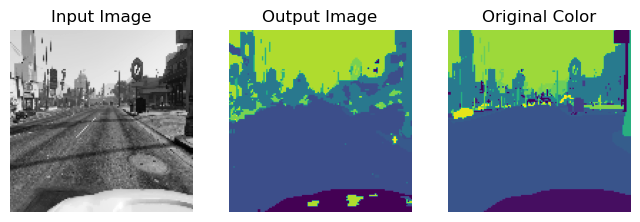

In [371]:
trained_seg_model.eval()
batch_size = 10
# Iterate through the test data
test_loader = DataLoader(s_test_dataset, batch_size=batch_size, shuffle=True)

counter = 0
for batch in test_loader:
    inputs, labels = batch  # You can ignore the labels
    if counter == 3:
        break
    else:
        counter += 1

    # Perform inference
    with torch.no_grad():
        outputs = trained_seg_model(inputs.to(device))

    # View the input and output images
    for i in range(3):
        input_img = inputs[i].squeeze().cpu()*50 + 50 # rescale [-1,1] --> [0, 100]
        input_labels = labels[i].cpu() # rescale [-1,1] --> [-128, 128]
        output_img = outputs[i].cpu() # rescale [-1,1] --> [-128, 128]
        
        
        print(torch.sum(output_img, dim = 0).shape)
        # Network computed image
        output_indices = torch.argmax(output_img, dim = 0)
        
       
        original_segmented_img = torch.sum(input_labels, dim = 0).numpy()
        
        # Display the input and output images side by side
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(input_img, cmap='gray')
        plt.title('Input Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(output_indices.numpy())
        plt.title('Output Image')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(original_segmented_img)
        plt.title('Original Color')
        plt.axis('off')

        plt.show()

## 3.3 Save model

In [372]:

torch.save({'model_state_dict': trained_seg_model.state_dict(),
            'train_losses': train_seg_losses,
            'val_losses': val_seg_losses,
            }, "./trained_seg_model.ckpt")

# Example of creating and initialising model with a previously saved state dict:
saved_seg_model = SegModel() # fill-in the arguments if needed
checkpoint = torch.load("trained_seg_model.ckpt")
saved_seg_model.load_state_dict(checkpoint['model_state_dict'])

# Example of re-using saved statistics:
print("Validation accuracies:", checkpoint['val_losses'])

Validation accuracies: [1.581987996896108, 1.387422353029251, 1.2396417260169983, 1.239729642868042, 1.2179510990778606, 1.1276045342286427, 1.1349057604869206, 1.0862642675638199, 1.0823046068350475, 1.0543056180079777]


## 4. Create an Autoencoder that uses the Network  in 3.

Combine Semantic segmentation with a new autoencoder to colorize images.

### 4.1 Create Combined Model 

In [15]:
AutoEncoder2 = nn.Sequential(
    nn.Conv2d(2, 64, kernel_size=3, padding=1),
    nn.LeakyReLU(),  
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.LeakyReLU(),
    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.Dropout(0.5),
    nn.Conv2d(256, 128, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.BatchNorm2d(128),
    nn.Conv2d(128, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.Tanh(),
    nn.Conv2d(64, 2, kernel_size=3, padding=1),
    nn.Dropout(0.1),
    nn.Tanh()  
)




class CombinedModel(nn.Module):
    def __init__(self, modelA, modelB):
        super(CombinedModel, self).__init__()
        self.modelA = modelA # semantic segmentation
        self.modelB = modelB # colorization
        
        
    def forward(self, x):
        L = x
        seg = self.modelA(x)                     # [nr_channels, img_size, img_size]
        seg_one_img = torch.argmax(seg, dim = 1) # [img_size, img_size]
        LSeg = torch.cat([L,seg_one_img.unsqueeze(1)], dim=1) # [2, img_size, img_size]
        ab = self.modelB(LSeg)
        
        
        return ab


saved_seg_model = SegModel() # fill-in the arguments if needed
checkpoint = torch.load("trained_seg_model.ckpt")
saved_seg_model.load_state_dict(checkpoint['model_state_dict'])
combined = CombinedModel(saved_seg_model, AutoEncoder2)


### 4.2 Freeze Layers

In [16]:
for param in saved_seg_model.parameters():
    param.requires_grad = False

In [17]:
crop_size = (128, 128)
gta_combined_transform = Compose([ToTensor(), Resize(crop_size, interpolation=Image.NEAREST)])#Compose([ToTensor(), Resize((img_size, img_size), antialias=True)])
gta_combined_dataset = GTALabData(path, gta_combined_transform)

val_ratio = 0.15
test_ratio = 0.15

n_samples = len(gta_combined_dataset)
n_val_samples = int(n_samples * val_ratio)
n_test_samples = int(n_samples * test_ratio)
n_train_samples = n_samples - n_val_samples - n_test_samples

combined_train_dataset, combined_val_dataset, combined_test_dataset = random_split(
    gta_combined_dataset, [n_train_samples, n_val_samples, n_test_samples]
)

In [20]:
# YOUR CODE HERE
batch_size = 32


train_loader = DataLoader(combined_train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(combined_val_dataset, batch_size=batch_size, shuffle=True)



optimizer = optim.Adam(combined.parameters(), lr =0.001) 
loss_fn = nn.MSELoss()
num_epochs = 10
print_every = 1


    
trained_combined_model, train_losses, val_losses = training_loop(combined, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every)

Starting training
Batch 1/55: Train loss: 0.106
Batch 2/55: Train loss: 0.272
Batch 3/55: Train loss: 0.099
Batch 4/55: Train loss: 0.045
Batch 5/55: Train loss: 0.034
Batch 6/55: Train loss: 0.021
Batch 7/55: Train loss: 0.014
Batch 8/55: Train loss: 0.010
Batch 9/55: Train loss: 0.009
Batch 10/55: Train loss: 0.007
Batch 11/55: Train loss: 0.005
Batch 12/55: Train loss: 0.006
Batch 13/55: Train loss: 0.006
Batch 14/55: Train loss: 0.005
Batch 15/55: Train loss: 0.005
Batch 16/55: Train loss: 0.005
Batch 17/55: Train loss: 0.005
Batch 18/55: Train loss: 0.004
Batch 19/55: Train loss: 0.004
Batch 20/55: Train loss: 0.004
Batch 21/55: Train loss: 0.005
Batch 22/55: Train loss: 0.005
Batch 23/55: Train loss: 0.005
Batch 24/55: Train loss: 0.006
Batch 25/55: Train loss: 0.004
Batch 26/55: Train loss: 0.004
Batch 27/55: Train loss: 0.005
Batch 28/55: Train loss: 0.004
Batch 29/55: Train loss: 0.004
Batch 30/55: Train loss: 0.005
Batch 31/55: Train loss: 0.004
Batch 32/55: Train loss: 0.004

### 4.3 Evaluate Results

torch.Size([3, 128, 128]) o


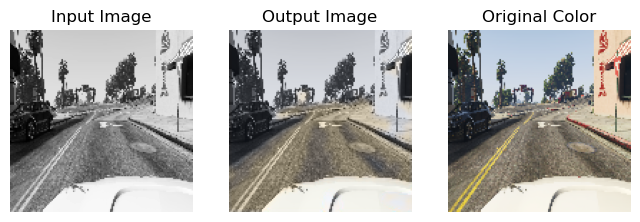

torch.Size([3, 128, 128]) o


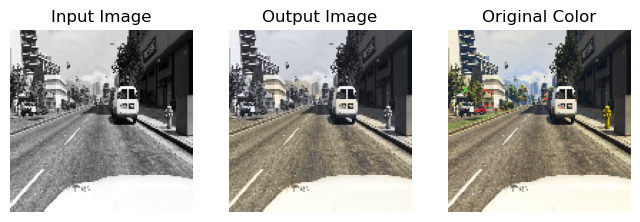

torch.Size([3, 128, 128]) o


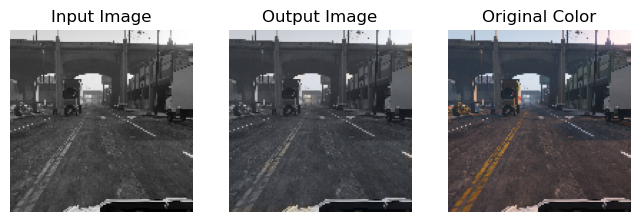

torch.Size([3, 128, 128]) o


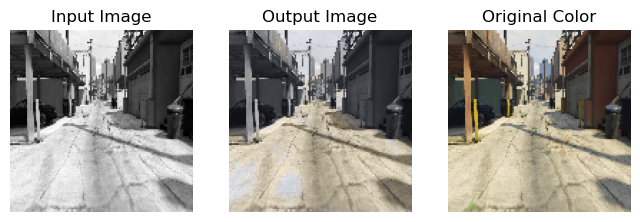

torch.Size([3, 128, 128]) o


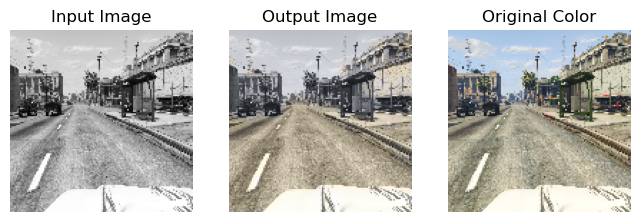

torch.Size([3, 128, 128]) o


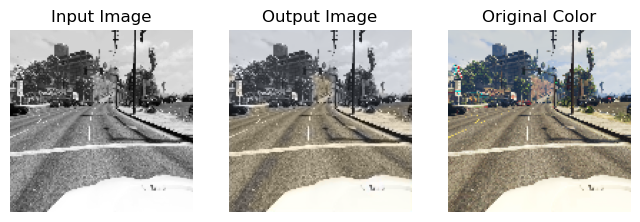

torch.Size([3, 128, 128]) o


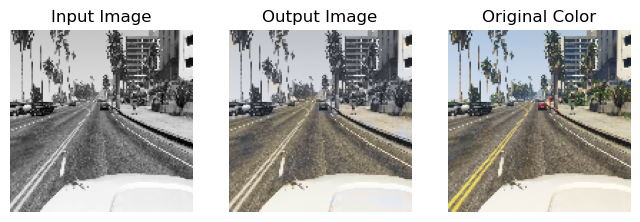

torch.Size([3, 128, 128]) o


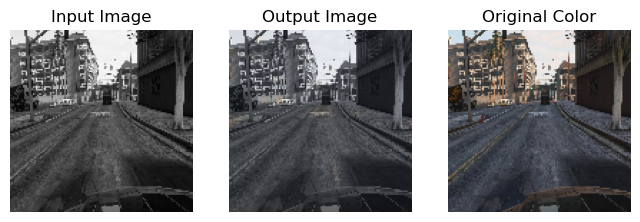

torch.Size([3, 128, 128]) o


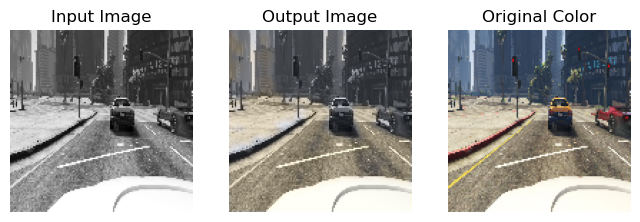

In [21]:
trained_combined_model.eval()

#print(test_image.shape)
batch_size = 10
# Iterate through the test data
test_loader = DataLoader(combined_test_dataset, batch_size=batch_size, shuffle=True)


counter = 0
for batch in test_loader:
    inputs, labels = batch  # You can ignore the labels
    if counter == 3:
        break
    else:
        counter += 1

    # Perform inference
    with torch.no_grad():
        outputs = trained_combined_model(inputs.to(device))

    # View the input and output images
    for i in range(3):
        input_img = inputs[i].squeeze().cpu()*50 + 50 # rescale [-1,1] --> [0, 100]
        input_labels = labels[i].squeeze().cpu()*128 # rescale [-1,1] --> [-128, 128]
        output_img = outputs[i].cpu()*128 # rescale [-1,1] --> [-128, 128]
        

        # Network computed image
        color_img = torch.cat((input_img.unsqueeze(0) ,output_img[0].unsqueeze(0), output_img[1].unsqueeze(0)), dim=0).cpu() # restore Lab image
        color_img = kornia.color.lab_to_rgb(color_img) #Lab --> RGB
        color_img = color_img.permute(1, 2, 0).cpu().numpy()
        

        # Original Image
        #input_labels = F.interpolate(input_labels.unsqueeze(1), size=(img_size, img_size), mode='bilinear', align_corners=False).squeeze(1).cpu()
        original_color_image = torch.cat((input_img.unsqueeze(0) ,input_labels[0].unsqueeze(0), input_labels[1].unsqueeze(0)), dim=0)
        original_color_image = kornia.color.lab_to_rgb(original_color_image)
        print(original_color_image.shape, 'o')

        # Display the input and output images side by side
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(input_img, cmap='gray')
        plt.title('Input Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(color_img)
        plt.title('Output Image')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(original_color_image.permute(1, 2, 0).numpy())
        plt.title('Original Color')
        plt.axis('off')

        plt.show()

#output = trained_gta_model(test_image)
#test_dataloader = DataLoader()

### 4.4 Save Model

In [23]:

torch.save({'model_state_dict': trained_combined_model.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            }, "./trained_combined_model.ckpt")
'''
# Example of creating and initialising model with a previously saved state dict:
saved_combined_model = CombinedModel() # fill-in the arguments if needed
checkpoint = torch.load("trained_combined_model.ckpt")
saved_combined_model.load_state_dict(checkpoint['model_state_dict'])

# Example of re-using saved statistics:
print("Validation accuracies:", checkpoint['val_losses'])
'''

'\n# Example of creating and initialising model with a previously saved state dict:\nsaved_combined_model = CombinedModel() # fill-in the arguments if needed\ncheckpoint = torch.load("trained_combined_model.ckpt")\nsaved_combined_model.load_state_dict(checkpoint[\'model_state_dict\'])\n\n# Example of re-using saved statistics:\nprint("Validation accuracies:", checkpoint[\'val_losses\'])\n'

## 5. Compare the Two Autoencoders

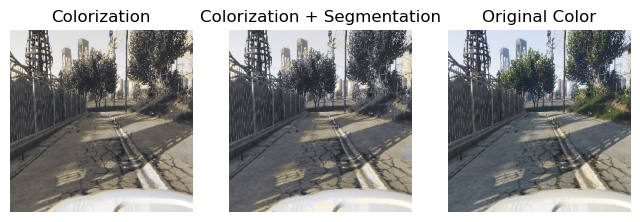

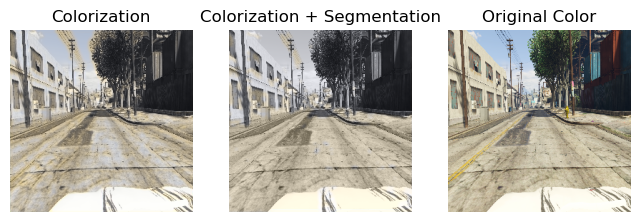

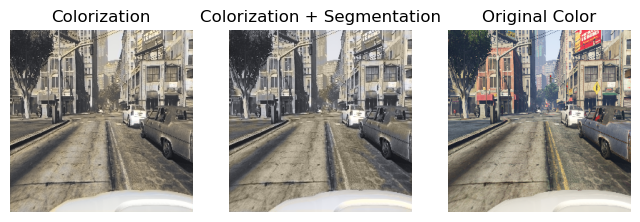

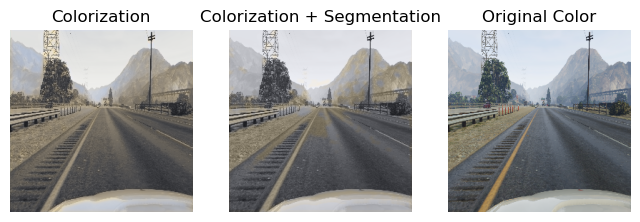

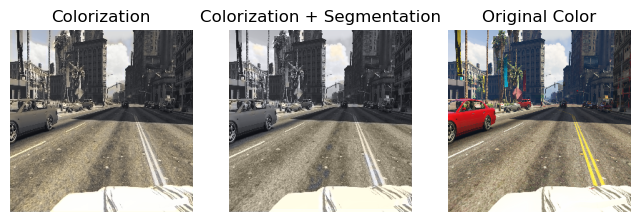

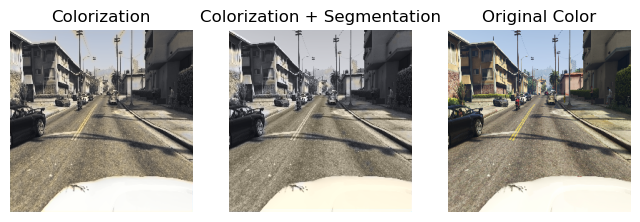

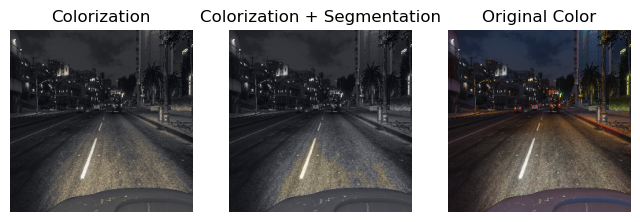

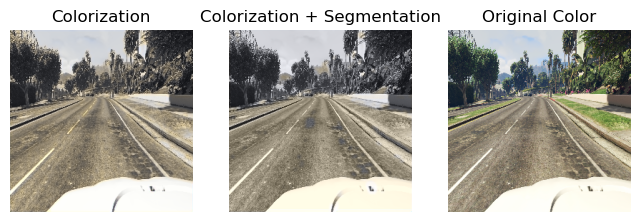

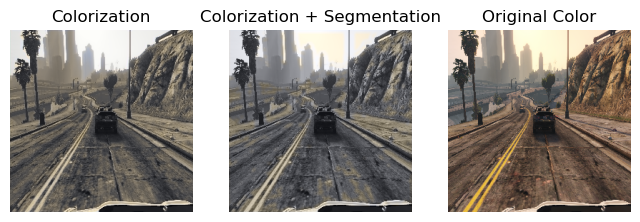

In [24]:


#Load Old Model no Segmentation

saved_single_model = AutoEncoder() # fill-in the arguments if needed
checkpoint = torch.load("trained_single_model.ckpt")
saved_single_model.load_state_dict(checkpoint['model_state_dict'])

#Load Seg Model
saved_seg_model = SegModel() # fill-in the arguments if needed
checkpoint = torch.load("trained_seg_model.ckpt")
saved_seg_model.load_state_dict(checkpoint['model_state_dict'])

#Load New Model with Segmentation

saved_combined_model = CombinedModel(saved_seg_model, AutoEncoder2)
checkpoint = torch.load("trained_combined_model.ckpt")
saved_combined_model.load_state_dict(checkpoint['model_state_dict'])

batch_size = 10
crop_size = (256, 256)
transform =  Compose([ToTensor(), Resize(crop_size, interpolation=Image.NEAREST)])
newDataset = GTALabData(path, transform)
L, ab = newDataset[5]

test_loader = DataLoader(newDataset, batch_size=batch_size, shuffle=True)


counter = 0
for batch in test_loader:
    L, ab = batch  # You can ignore the labels
    if counter >= 3:
        break
    else:
        counter += 1
    

    # Get output Data
    saved_single_model.eval()
    with torch.no_grad():
        output1 = saved_single_model(L)


    trained_combined_model.eval()
    with torch.no_grad():
        output2 = trained_combined_model(L.to(device))

    for i in range(3):

        #Make Plots

        input_img = L[i].squeeze().cpu()*50 + 50 # rescale [-1,1] --> [0, 100]
        input_labels = ab[i].squeeze().cpu()*128 # rescale [-1,1] --> [-128, 128]
        output_single = output1[i].cpu()*128 # rescale [-1,1] --> [-128, 128]
        output_combined = output2[i].cpu()*128

        # AutoEnconder
        auto_img = torch.cat((input_img.unsqueeze(0) ,output_single[0].unsqueeze(0), output_single[1].unsqueeze(0)), dim=0).cpu() # restore Lab image
        auto_img = kornia.color.lab_to_rgb(auto_img) #Lab --> RGB
        auto_img = auto_img.permute(1,2,0)
        

        # CombinedModel
        combined_img = torch.cat((input_img.unsqueeze(0) ,output_combined[0].unsqueeze(0), output_combined[1].unsqueeze(0)), dim=0).cpu() # restore Lab image
        combined_img = kornia.color.lab_to_rgb(combined_img) #Lab --> RGB
        combined_img = combined_img.permute(1, 2, 0)
        

        # Original Image
        
        original_color_image = torch.cat((input_img.unsqueeze(0) ,input_labels[0].unsqueeze(0), input_labels[1].unsqueeze(0)), dim=0)
        original_color_image = kornia.color.lab_to_rgb(original_color_image)


        # Display the input and output images side by side
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(auto_img)
        plt.title('Colorization')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(combined_img)
        plt.title('Colorization + Segmentation')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(original_color_image.permute(1, 2, 0).numpy())
        plt.title('Original Color')
        plt.axis('off')

        plt.show()

### 5.2 Compare test sets

torch.Size([32, 1, 128, 128])
torch.Size([32, 1, 128, 128])
torch.Size([32, 1, 128, 128])
torch.Size([32, 1, 128, 128])
torch.Size([32, 1, 128, 128])
torch.Size([32, 1, 128, 128])
torch.Size([32, 1, 128, 128])
torch.Size([32, 1, 128, 128])
torch.Size([32, 1, 128, 128])
torch.Size([32, 1, 128, 128])
torch.Size([32, 1, 128, 128])
torch.Size([23, 1, 128, 128])


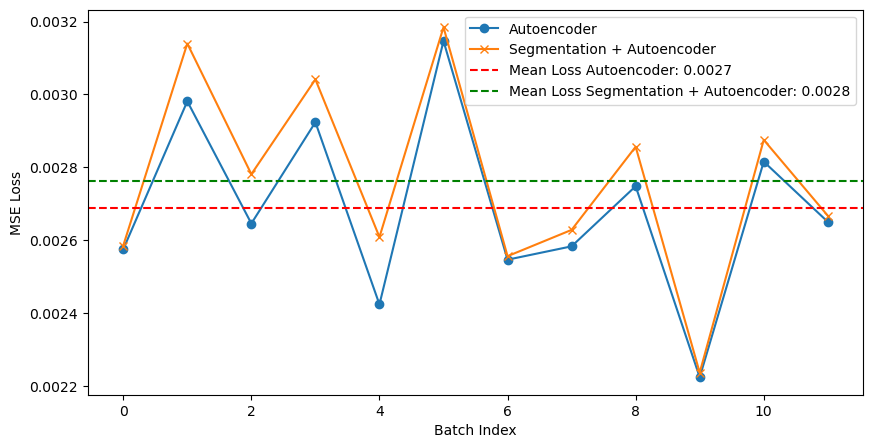

In [63]:
# Load the test dataset
batch_size = 32
test_loader = DataLoader(combined_test_dataset, batch_size=batch_size, shuffle=False)

# Initialize lists for loss values
model1_losses = []
model2_losses = []

# Iterate through the test dataset
for images, labels in test_loader:
    print(images.shape)

    # Get output Data
    saved_single_model.eval()
    with torch.no_grad():
        outputs1 = saved_single_model(images)


    trained_combined_model.eval()
    with torch.no_grad():
        outputs2 = trained_combined_model(images.to(device))
    
    # Calculate the MSE loss for each model
    loss1 = F.mse_loss(outputs1, labels)
    loss2 = F.mse_loss(outputs2, labels.to(device))
    
    # Append the loss values to the lists
    model1_losses.append(loss1.item())
    model2_losses.append(loss2.item())

# Calculate mean loss values for Autoencoder and Segmentation + Autoencoder
mean_loss_autoencoder = sum(model1_losses) / len(model1_losses)
mean_loss_seg_autoencoder = sum(model2_losses) / len(model2_losses)

# Plot the loss values for comparison
plt.figure(figsize=(10, 5))
plt.plot(model1_losses, label='Autoencoder', marker='o')
plt.plot(model2_losses, label='Segmentation + Autoencoder', marker='x')
plt.axhline(mean_loss_autoencoder, color='r', linestyle='--', label=f'Mean Loss Autoencoder: {mean_loss_autoencoder:.4f}')
plt.axhline(mean_loss_seg_autoencoder, color='g', linestyle='--', label=f'Mean Loss Segmentation + Autoencoder: {mean_loss_seg_autoencoder:.4f}')
plt.xlabel('Batch Index')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

### 5.3 plot segmentaion accuracy

53.98998260498047
56.69422149658203
54.26158905029297
51.05705261230469
51.13086700439453
54.83570098876953
54.252052307128906
54.96101379394531
55.112266540527344
55.54180145263672
54.543304443359375
51.5380859375


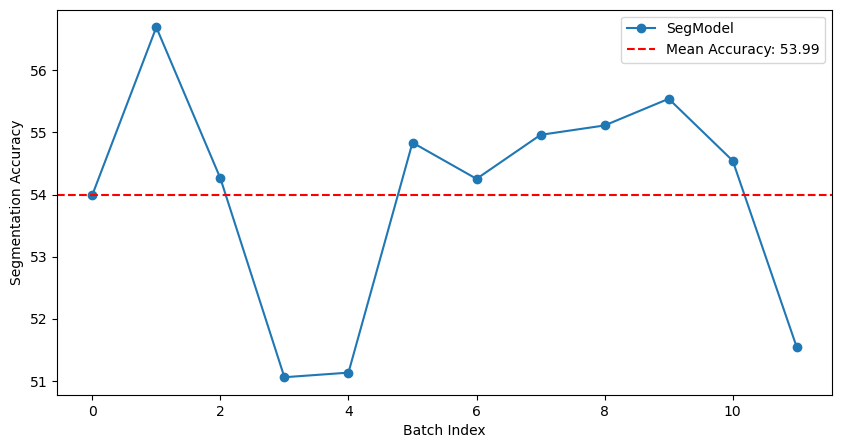

In [90]:


# Load the test dataset
test_loader = DataLoader(s_test_dataset, batch_size=batch_size, shuffle=False)

# Initialize a list to store accuracy values for each batch
seg_accuracy = []

# Iterate through the test dataset
for batch_index, (images, labels) in enumerate(test_loader, 1):
  

    # Get output Data
    saved_seg_model.eval()
    with torch.no_grad():
        outputs = saved_seg_model(images)


    # Calculate the Cross entropy loss
    #loss = F.cross_entropy(outputs, labels.squeeze(1).long())
    predicted = torch.argmax(outputs, dim = 1)
    
    #_, predicted = torch.max(outputs, 1)

    # Calculate batch accuracy
    correct = (predicted == labels.squeeze(1)).sum().item()
    total = predicted.size(0)*predicted.size(1)**2

    
    batch_accuracy = (correct / total) * 100  # Calculate accuracy as a percentage
    print(batch_accuracy)
    seg_accuracy.append(batch_accuracy)

mean_acc = sum(seg_accuracy) / len(seg_accuracy)
# Plot the accuracy values for each batch
plt.figure(figsize=(10, 5))
plt.plot(seg_accuracy, label='SegModel', marker='o')
plt.axhline(mean_acc, color='r', linestyle='--', label=f'Mean Accuracy: {mean_acc:.2f}')
plt.xlabel('Batch Index')
plt.ylabel('Segmentation Accuracy')

plt.legend()
plt.show()
